# 02 - Forward Models: Ray vs Fresnel

Compare geometry and matrix behavior for `seismictomo` (ray) and `seismicwavetomo` (Fresnel).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.cmap'] = 'viridis'
from pyprseimsic import phantom_gallery, prseismic, seismicwavetomo, seismictomo

## Acquisition geometry (sources on right, receivers on left + top)

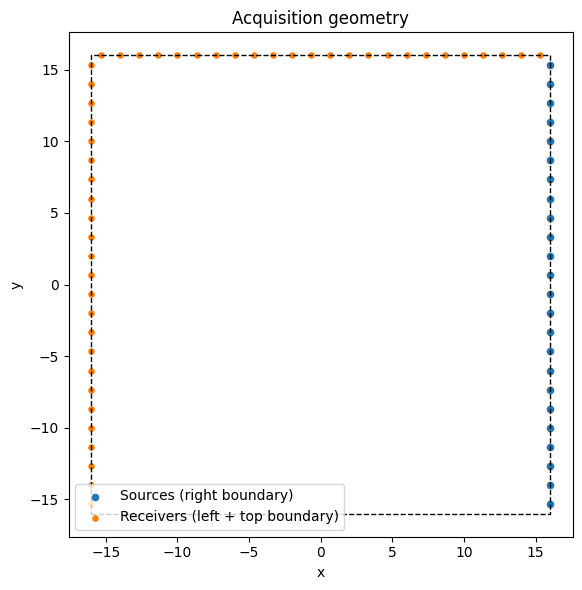

In [2]:
def geometry_points(N: int, s: int, p: int):
    N2 = N / 2
    Ns = (N / s) / 2
    x0 = N2 * np.ones(s)
    y0 = np.linspace(-N2 + Ns, N2 - Ns, s)

    p1 = int(np.ceil(p / 2))
    p2 = int(np.floor(p / 2))
    Np1 = (N / p1) / 2
    Np2 = (N / p2) / 2

    xp = np.concatenate([
        -N2 * np.ones(p2),
        np.linspace(-N2 + Np1, N2 - Np1, p1),
    ])
    yp = np.concatenate([
        np.linspace(-N2 + Np2, N2 - Np2, p2),
        N2 * np.ones(p1),
    ])
    return x0, y0, xp, yp

N = 32
s = 24
p = 48
x0, y0, xp, yp = geometry_points(N, s, p)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x0, y0, s=20, label='Sources (right boundary)')
ax.scatter(xp, yp, s=14, label='Receivers (left + top boundary)')
ax.plot([-N/2, N/2, N/2, -N/2, -N/2], [-N/2, -N/2, N/2, N/2, -N/2], 'k--', lw=1)
ax.set_aspect('equal')
ax.set_title('Acquisition geometry')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower left')
plt.tight_layout()


## Build ray and Fresnel system matrices

In [3]:
omega = 10.0
A_ray = seismictomo(N, s, p, sparse_matrix=True)
A_fresnel = seismicwavetomo(N, s, p, omega=omega, sparse_matrix=True)

print('Ray    shape:', A_ray.shape, 'nnz:', A_ray.nnz, 'density:', A_ray.nnz / (A_ray.shape[0] * A_ray.shape[1]))
print('Fresnel shape:', A_fresnel.shape, 'nnz:', A_fresnel.nnz, 'density:', A_fresnel.nnz / (A_fresnel.shape[0] * A_fresnel.shape[1]))
assert A_ray.nnz > 0
assert A_fresnel.nnz > 0


Ray    shape: (1152, 1024) nnz: 40854 density: 0.034632364908854164
Fresnel shape: (1152, 1024) nnz: 187955 density: 0.15933142768012154


## Sparsity patterns

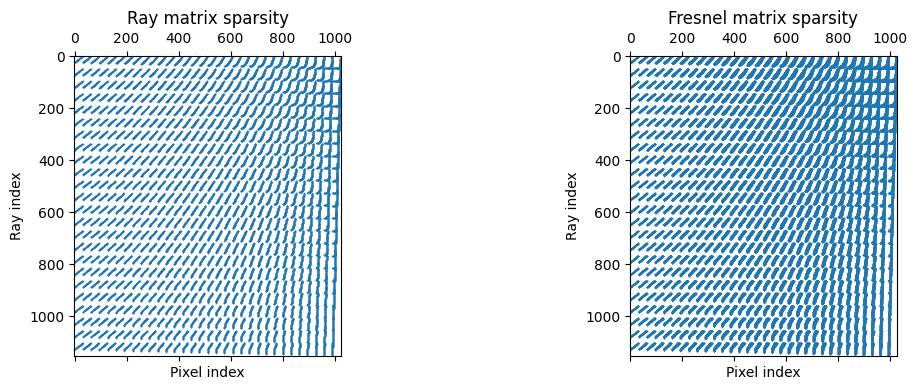

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].spy(A_ray, markersize=0.25)
axes[0].set_title('Ray matrix sparsity')
axes[0].set_xlabel('Pixel index')
axes[0].set_ylabel('Ray index')

axes[1].spy(A_fresnel, markersize=0.25)
axes[1].set_title('Fresnel matrix sparsity')
axes[1].set_xlabel('Pixel index')
axes[1].set_ylabel('Ray index')

plt.tight_layout()


## Single source-receiver sensitivity map (same row index)

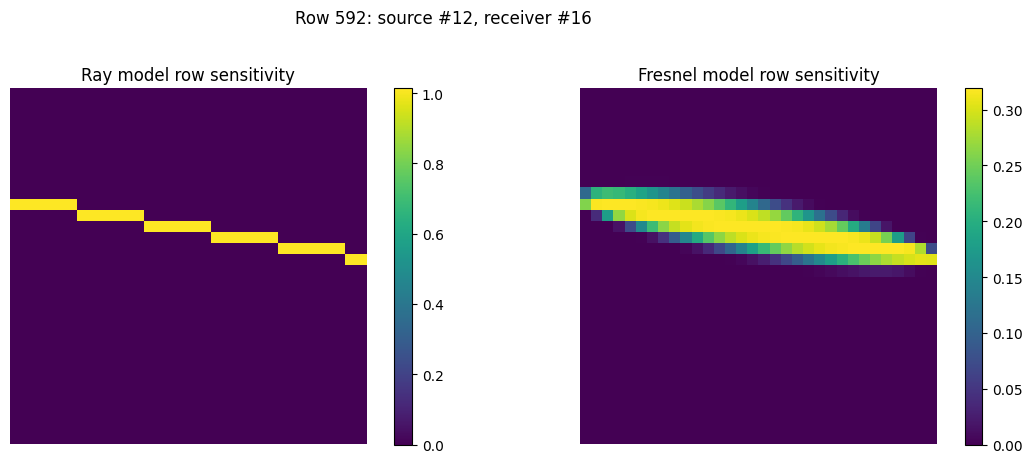

In [5]:
ray_idx = (s // 2) * p + (p // 3)
i = ray_idx // p
j = ray_idx % p

ray_map = A_ray.getrow(ray_idx).toarray().ravel().reshape((N, N), order='F')
fresnel_map = A_fresnel.getrow(ray_idx).toarray().ravel().reshape((N, N), order='F')

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
im0 = axes[0].imshow(ray_map)
axes[0].set_title('Ray model row sensitivity')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(fresnel_map)
axes[1].set_title('Fresnel model row sensitivity')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

fig.suptitle(f'Row {ray_idx}: source #{i}, receiver #{j}', y=1.02)
plt.tight_layout()


## Fresnel `omega` effect

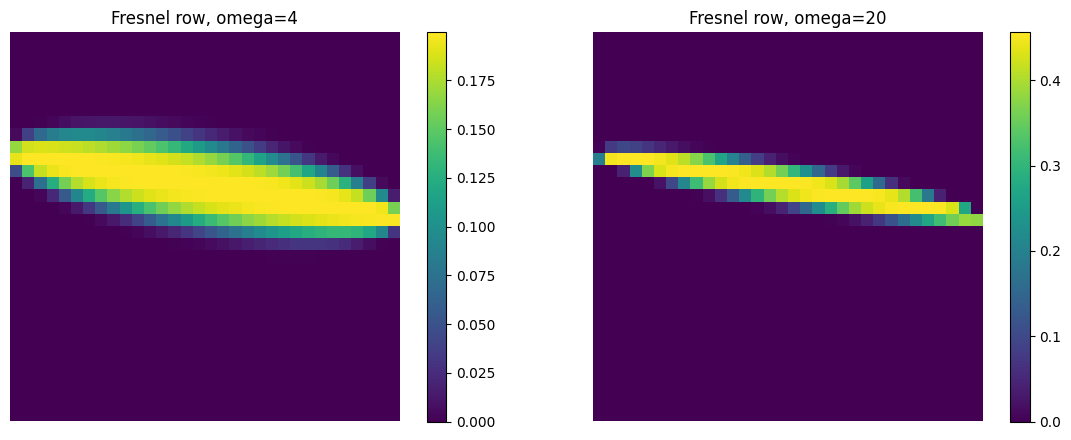

In [6]:
A_fresnel_low = seismicwavetomo(N, s, p, omega=4.0, sparse_matrix=True)
A_fresnel_high = seismicwavetomo(N, s, p, omega=20.0, sparse_matrix=True)

low_map = A_fresnel_low.getrow(ray_idx).toarray().ravel().reshape((N, N), order='F')
high_map = A_fresnel_high.getrow(ray_idx).toarray().ravel().reshape((N, N), order='F')

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
im0 = axes[0].imshow(low_map)
axes[0].set_title('Fresnel row, omega=4')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(high_map)
axes[1].set_title('Fresnel row, omega=20')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()


## End-to-end comparison on the same phantom

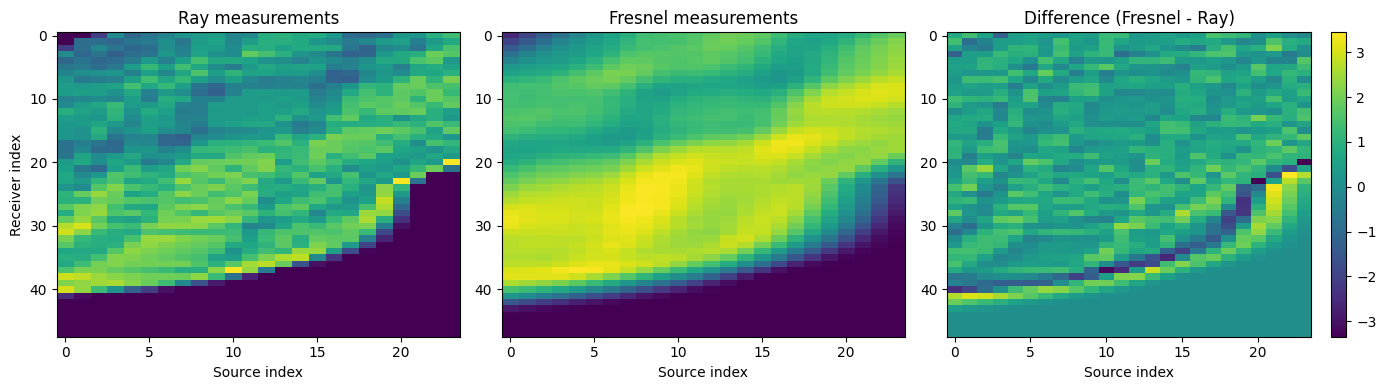

In [7]:
phantom = phantom_gallery('shepplogan', N)
prob_ray = prseismic(N, phantom=phantom, wave_model='ray', s=s, p=p)
prob_fresnel = prseismic(N, phantom=phantom, wave_model='fresnel', s=s, p=p, omega=omega)

b_ray = prob_ray.b.reshape((p, s), order='F')
b_fresnel = prob_fresnel.b.reshape((p, s), order='F')

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(b_ray, aspect='auto')
axes[0].set_title('Ray measurements')
axes[0].set_xlabel('Source index')
axes[0].set_ylabel('Receiver index')

axes[1].imshow(b_fresnel, aspect='auto')
axes[1].set_title('Fresnel measurements')
axes[1].set_xlabel('Source index')

im2 = axes[2].imshow(b_fresnel - b_ray, aspect='auto')
axes[2].set_title('Difference (Fresnel - Ray)')
axes[2].set_xlabel('Source index')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()


## Sparse-vs-LinearOperator sanity checks

In [8]:
Ncheck = 24
scheck = 16
pcheck = 32
rng = np.random.default_rng(0)

A_ray_sparse = seismictomo(Ncheck, scheck, pcheck, sparse_matrix=True)
A_ray_lin = seismictomo(Ncheck, scheck, pcheck, sparse_matrix=False)
x = rng.random(Ncheck * Ncheck)
y = rng.random(scheck * pcheck)
np.testing.assert_allclose(A_ray_sparse @ x, A_ray_lin.matvec(x), atol=1e-12)
np.testing.assert_allclose(A_ray_sparse.T @ y, A_ray_lin.rmatvec(y), atol=1e-12)

A_fr_sparse = seismicwavetomo(Ncheck, scheck, pcheck, omega=8.0, sparse_matrix=True)
A_fr_lin = seismicwavetomo(Ncheck, scheck, pcheck, omega=8.0, sparse_matrix=False)
np.testing.assert_allclose(A_fr_sparse @ x, A_fr_lin.matvec(x), atol=1e-12)
np.testing.assert_allclose(A_fr_sparse.T @ y, A_fr_lin.rmatvec(y), atol=1e-12)

print('All sparse-vs-linop checks passed.')


All sparse-vs-linop checks passed.
